In [84]:
import snap
import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd
import leidenalg 
import igraph as ig
import networkx as nx
from collections import defaultdict
sys.path.append('../')
from src.util_data import loadNodeAttr
from src.util import getInletIds, getOutletIds
from src.data_cleaning.snair.clean_am import *

ImportError: No module named data_cleaning.snair.clean_am

In [77]:
def get_pos(txt_file):
    LS = read_am(txt_file)
    LS_edge_prop = edgeProps(LS)
# assert(len(LS_edge_prop)==len(LS[2]))
    LS_clean = cleanEdgelist(LS, LS_edge_prop)
    coordinates = {}
    for edge, attr in LS_clean.values():
        coordinates[edge[0]] = np.asarray(attr['srcCords'])
        coordinates[edge[1]] = np.asarray(attr['dstCords'])
#     return dict(zip(range(coordinates.shape[0]), coordinates))
    return coordinates

In [78]:
G_LS174T = ig.Graph.Read_Ncol('../data/Edgelist_v2/LS174T_clean_EdgesList.txt', names= True, weights="if_present", directed=True)
G_SW1222 = ig.Graph.Read_Ncol('../data/Edgelist_v2/SW1222_clean_EdgesList.txt', names= True, weights="if_present", directed=True)
G_Mes = ig.Graph.Read_Ncol('../data/Edgelist/Mesentery_clean_EdgeList.txt', names= True, weights="if_present", directed=True)

In [79]:
part_LS = leidenalg.find_partition(G_LS174T, leidenalg.RBConfigurationVertexPartition)
part_SW = leidenalg.find_partition(G_SW1222, leidenalg.RBConfigurationVertexPartition)
part_Mes = leidenalg.find_partition(G_Mes, leidenalg.RBConfigurationVertexPartition)

In [22]:
part_LS = leidenalg.find_partition(G_LS174T, leidenalg.ModularityVertexPartition)
part_SW = leidenalg.find_partition(G_SW1222, leidenalg.ModularityVertexPartition)
part_Mes = leidenalg.find_partition(G_Mes, leidenalg.ModularityVertexPartition)

In [80]:
G_LS174T = snap.LoadEdgeList(snap.PNGraph, "../data/Edgelist_v2/LS174T_clean_EdgesList.txt", 0, 1, '\t')
nidx2clust_LS = {}
total = set()
for i,x in enumerate(part_LS):
    for y in x:
        if G_LS174T.IsNode(y):
            total.add(y)
            nidx2clust_LS[y] = i
# print(set(range(G_LS174T.GetNodes())) - total)
unique, counts = np.unique(nidx2clust_LS.values(), return_counts = True)
print "Number of communities = %d, largest community = %d"%(len(unique), np.amax(counts))

Number of communities = 157, largest community = 462


In [81]:
community_LS = defaultdict(set)
for node, community in nidx2clust_LS.items():
    community_LS[community].add(node)
community_LS = dict(community_LS)

In [83]:
G_LS=nx.Graph()
G_LS.add_nodes_from(community_LS.keys())
# print G_LS174T.IsNode(node)
# G_LS174T.GetNI(12959).GetOutEdges()
for community, nodes in community_LS.items():
    nbrs = set()
    for node in nodes:
        node_nbr = [nbrs.add(nbr) for nbr in G_LS174T.GetNI(node).GetOutEdges()]
    for community2, nodes2 in community_LS.items():
        if community == community2:
            continue
        if nodes2 &nbrs:
            G_LS.add_edge(community, community2)
community_sizes = [len(val) for val in community_LS.values()]
community_position = []
coordinates = get_pos('../data/og_files/LS174T_spatialGraph_RIN.txt')
community_coordinates = {}
for community, nodes in community_LS.items():
    sum_coord = np.asarray([0,0,0])
    for node in nodes:
        sum_coord += coordinates[node]
    community_coordinates[community] = sum_coord/float(len(nodes))

NameError: global name 'read_am' is not defined

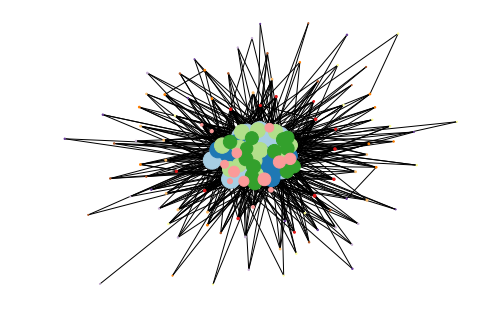

In [70]:
LS174T_pos = get_pos('../data/og_files/LS174T_coordinates.txt')
nx.draw(G_LS, node_color=np.arange(len(community_LS)), node_size=community_sizes, cmap=plt.cm.Paired)

In [33]:
nidx2clust_SW = {}
for i,x in enumerate(part_SW):
    for y in x:
        nidx2clust_SW[y] = i
unique, counts = np.unique(nidx2clust_SW.values(), return_counts = True)
print "Number of communities = %d, largest community = %d"%(len(unique), np.amax(counts))

Number of communities = 1010, largest community = 954


In [24]:
community_SW = defaultdict(list)
for i,node in enumerate(nidx2clust_SW):
    community_SW[node].append(i)

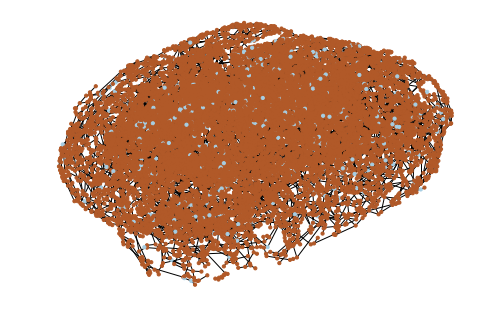

In [31]:
G_LS174T_nx = nx.read_edgelist("../data/Edgelist_v2/LS174T_clean_EdgesList.txt", nodetype=int)
LS174T_pos = get_pos('../data/og_files/LS174T_coordinates.txt')
# print(LS174T_pos)
nx.draw(G_LS174T_nx, node_color=np.asarray(nidx2clust_LS.values()), pos = LS174T_pos, node_size=10, cmap=plt.cm.Paired)
plt.savefig('LS_clustering.pdf')

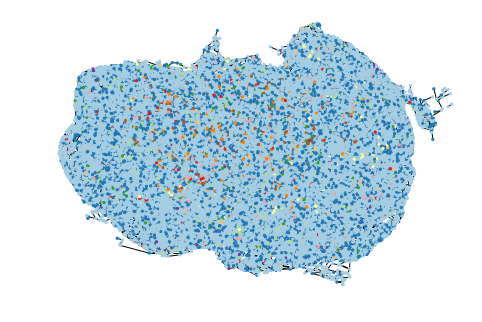

In [26]:
G_SW1222_nx = nx.read_edgelist("../data/Edgelist_v2/SW1222_clean_EdgesList.txt", nodetype=int)
SW1222_pos = get_pos('../data/og_files/SW1222_coordinates.txt')
# print(LS174T_pos)
nx.draw(G_SW1222_nx, node_color=np.asarray(nidx2clust_SW.values()), pos = SW1222_pos, node_size=5, cmap=plt.cm.Paired)
plt.savefig('SW_clustering.pdf')

In [9]:
np.savetxt('LS_communities.txt', nidx2clust_LS, delimiter = ' ')
np.savetxt('SW_communities.txt', nidx2clust_SW, delimiter = ' ')

In [11]:
radii_SW = loadNodeAttr('../data/og_files/SW122_spatialGraph_RIN.txt')
radii_LS = loadNodeAttr('../data/og_files/LS174T_spatialGraph_RIN.txt')
pressure_SW = loadNodeAttr('../data/og_files/SW122_spatialGraph_RIN.txt', attr = 'pressure')
pressure_LS = loadNodeAttr('../data/og_files/LS174T_spatialGraph_RIN.txt', attr = 'pressure')
flow_SW = loadNodeAttr('../data/og_files/SW122_spatialGraph_RIN.txt', attr = 'flow')
flow_LS = loadNodeAttr('../data/og_files/LS174T_spatialGraph_RIN.txt', attr = 'flow')

In [8]:
#Check flow consistency
G_LS174T = snap.LoadEdgeList(snap.PNGraph, "../data/Edgelist/LS174T_clean_EdgesList.txt", 0, 1, '\t')
G_SW1222 = snap.LoadEdgeList(snap.PNGraph, "../data/Edgelist/SW1222_clean_EdgesList.txt", 0, 1, '\t')
inlets_LS = getInletIds(G_LS174T)
inlets_SW = getInletIds(G_SW1222)
outlets_LS = getOutletIds(G_LS174T)
outlets_SW = getOutletIds(G_SW1222)
inlet_flow_LS = [flow_LS[inlet] for inlet in inlets_LS]
outlet_flow_LS = [flow_LS[outlet] for outlet in outlets_LS]
inlet_flow_SW = [flow_SW[inlet] for inlet in inlets_SW]
outlet_flow_SW = [flow_SW[outlet] for outlet in outlets_SW]

print np.sum(inlet_flow_LS)
print np.sum(outlet_flow_LS)
print np.sum(inlet_flow_SW)
print np.sum(outlet_flow_SW)

39489.88763162267
40710.2160796772
842943.4201301008
855436.2396368664


In [ ]:
community_radii_LS = defaultdict(list)
for i,node in enumerate(nidx2clust_LS):
    community_radii_LS[node].append(radii_LS[i])

In [19]:
community_flow_LS = defaultdict(list)
for i,node in enumerate(nidx2clust_LS):
    community_flow_LS[node].append(flow_LS[i])

In [20]:
community_pressure_LS = defaultdict(list)
for i,node in enumerate(nidx2clust_LS):
    community_pressure_LS[node].append(pressure_LS[i])

In [21]:
community_radii_SW = defaultdict(list)
for i,node in enumerate(nidx2clust_SW):
    community_radii_SW[node].append(radii_SW[i])

In [22]:
community_flow_SW = defaultdict(list)
for i,node in enumerate(nidx2clust_LS):
    community_flow_SW[node].append(flow_SW[i])

In [23]:
community_pressure_SW = defaultdict(list)
for i,node in enumerate(nidx2clust_SW):
    community_pressure_SW[node].append(pressure_SW[i])

In [ ]:
plt.hist(flow_LS.values(), bins = np.arange(0,100,1))
plt.plot()

In [ ]:
plt.hist(radii_LS.values(), bins = np.arange(5,20,0.5))
plt.plot()

In [ ]:
plt.hist(pressure_LS.values(), bins = np.arange(15,55,1))
plt.plot()

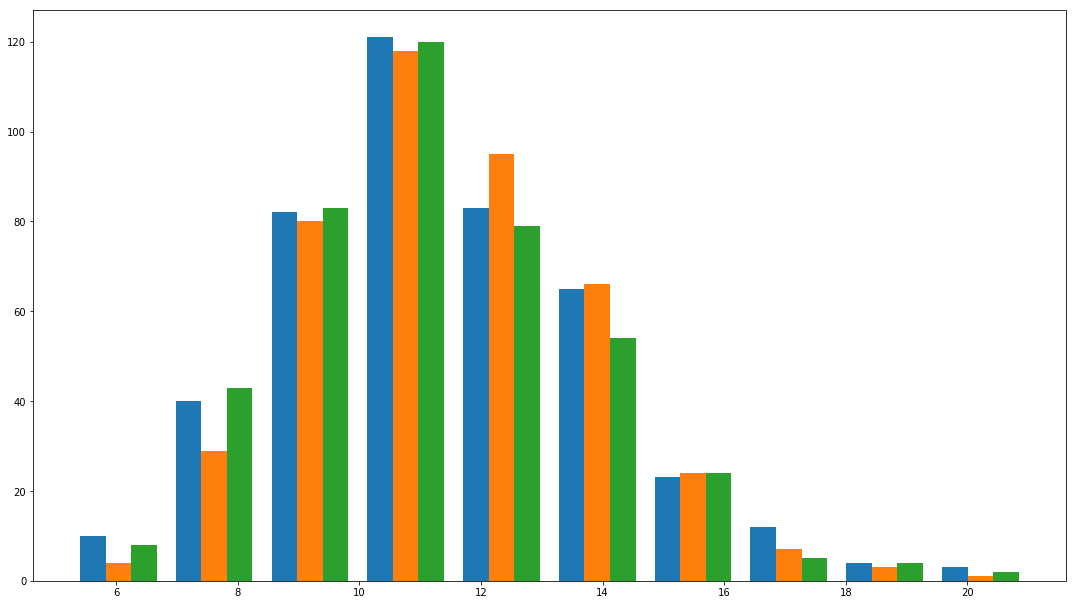

In [39]:
plt.hist(community_radii_LS.values()[:3])
# plt.gca().set_xscale('log')
plt.gcf().set_size_inches(18.5, 10.5)

In [ ]:
plt.hist(community_radii_LS[1], bins = np.arange(5,20,0.5))
# plt.gca().set_xscale('log')
# plt.gcf().set_size_inches(18.5, 10.5)

In [ ]:
plt.hist(community_radii_LS[2], bins = np.arange(5,20,0.5))
# plt.gca().set_xscale('log')
# plt.gcf().set_size_inches(18.5, 10.5)